In [8]:
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from skimage import color
from skimage import io
from skimage.transform import resize

import matplotlib.pyplot as plt
import torchvision
import imageio
import torch

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets as dset
import torchvision.utils as vutils
from LAG import LAG

from PIL import Image as im
import torch.nn as nn



In [9]:
transform = transforms.Compose([
                transforms.Resize(64),
                transforms.CenterCrop(64),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])
dataset = LAG("D:\workspace\DCGAN\PCA_DCGAN\LAG_dataset\dataset", transform=transform)
dataloader = DataLoader(dataset, shuffle=True, batch_size=64, num_workers=0)

In [10]:
def view_samples(images):
    img = torchvision.utils.make_grid(images, padding=2, normalize=True)
    img = img.cpu().numpy()
    plt.figure(figsize = (8, 8))
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.show()

torch.Size([64, 3, 64, 64])


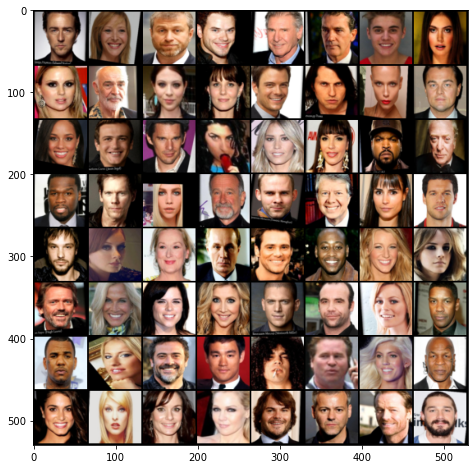

In [11]:
test = iter(dataloader)
sample = next(test)
print(sample.size())
view_samples(sample)

In [12]:
def save_progress(images, epoch, step):
    img = torchvision.utils.make_grid(images, padding=2, normalize=True)
    img = img.cpu().numpy()
    img = np.transpose(img, (1,2,0))
    img = np.uint8(img*255)
    imageio.imwrite(f"progress_pics/{epoch}-{step}.jpg", img)

In [13]:
def save_model_state(model, optimizer, loss, epoch, name):
    model_path = f"saved_models/{name}{epoch}.pt"
    state_dict = {
        'epoch' : epoch,
        'model_state_dict' : model.state_dict(),
        'opt_state_dict' : optimizer.state_dict(),
        'training_loss' : loss,
    }
    torch.save(state_dict, model_path)

In [14]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [15]:
class DiscriminatorModel(nn.Module):
    def __init__(self, n_c, n_fmps):
        super(DiscriminatorModel, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(n_c, n_fmps, 4, stride=2, padding=1),
            nn.BatchNorm2d(n_fmps),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(n_fmps, n_fmps*2, 4, stride=2, padding=1),
            nn.BatchNorm2d(n_fmps*2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(n_fmps*2, n_fmps*4, 4, stride=2, padding=1),
            nn.BatchNorm2d(n_fmps*4),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(n_fmps*4, n_fmps*8, 4, stride=2, padding=1),
            nn.BatchNorm2d(n_fmps*8),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(n_fmps * 8, 1, 4, stride=1, padding=0),
        )
        self.linear = nn.Linear(1, 1)
        self.net.apply(weights_init)
        self.linear.apply(weights_init)
    def forward(self, x):
        x = self.net(x)
        x = self.linear(x)
        return x.view(-1, 1, 1, 1)

In [16]:
class GeneratorModel(nn.Module):
    def __init__(self, n_z, n_fmps, n_c):
        super(GeneratorModel, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(n_z, n_fmps*8, 4, 1, 0),
            nn.BatchNorm2d(n_fmps*8),
            nn.LeakyReLU(0.2, True),
            nn.ConvTranspose2d(n_fmps*8, n_fmps*4, 4, 2, 1),
            nn.BatchNorm2d(n_fmps*4),
            nn.LeakyReLU(0.2, True),
            nn.ConvTranspose2d(n_fmps*4, n_fmps*2, 4, 2, 1),
            nn.BatchNorm2d(n_fmps*2),
            nn.LeakyReLU(0.2, True),
            nn.ConvTranspose2d(n_fmps*2, n_fmps*1, 4, 2, 1),
            nn.BatchNorm2d(n_fmps*1),
            nn.LeakyReLU(0.2, True),
            nn.ConvTranspose2d(n_fmps, n_c, 4, 2, 1),
            nn.Tanh()
        )
        self.net.apply(weights_init)

    def forward(self, x):
        x = self.net(x)
        return x

In [17]:
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


Fetch the 2000 imgs from celebA dataset

resize to 64 by 64

We can use the numpy flatten function to change the dimensions, that is from a matrix to a long vector of shape (64*64,) = (4096,)

In [18]:
#from ctypes import resize


sample_img = []

for i in range(2000):
    i += 1
    img = color.rgb2gray(io.imread(f'images/img_align_celeba/image{i}.jpg'))
    resized_img = resize(img, (64, 64))
    img2 = resized_img.flatten()
    sample_img.append(img2)

face_matrix = np.vstack(sample_img)

In [19]:
face_matrix = face_matrix.T
face_matrix.shape


(4096, 2000)

In [20]:
face_matrix

array([[0.91375412, 0.20909337, 1.        , ..., 0.04736872, 0.        ,
        0.0239377 ],
       [0.91375412, 0.21113009, 1.        , ..., 0.03825727, 0.        ,
        0.02222621],
       [0.91375412, 0.23045591, 1.        , ..., 0.04602657, 0.        ,
        0.0246039 ],
       ...,
       [0.25005558, 0.2987513 , 0.35338779, ..., 0.07659491, 0.1648603 ,
        0.68998729],
       [0.24322844, 0.38978326, 0.35480577, ..., 0.05505162, 0.16394056,
        0.85675182],
       [0.24384551, 0.46898309, 0.3647194 , ..., 0.09633563, 0.17770035,
        0.90357273]])

While trying to get the variance -covariance matrix for the data, numpy took a lot of time, that is where Pytorch comes in, to convert numpy array into a Pytorch tensor, use torch.as_tensor()

In [21]:
torchtensor = torch.as_tensor(face_matrix.T)
print(type(torchtensor))
print(torchtensor.shape)

<class 'torch.Tensor'>
torch.Size([2000, 4096])


Here is the effiecient implementation of PCA from Pytorch, we use this with the torch tensor.

In [22]:
U,S,V = torch.pca_lowrank(torchtensor, q=2000, center=True, niter=3)

In [23]:
U


tensor([[-0.0167, -0.0070, -0.0020,  ...,  0.0075, -0.0015,  0.0224],
        [ 0.0066,  0.0302, -0.0071,  ..., -0.0016, -0.0013,  0.0224],
        [-0.0154, -0.0044,  0.0242,  ...,  0.0210,  0.0100,  0.0224],
        ...,
        [ 0.0356,  0.0013,  0.0094,  ...,  0.0190, -0.0010,  0.0224],
        [ 0.0338,  0.0124, -0.0171,  ...,  0.0285, -0.0119,  0.0224],
        [-0.0072,  0.0125,  0.0034,  ..., -0.0008,  0.0009,  0.0224]],
       dtype=torch.float64)

In [24]:
torch.matmul(U, U.T)

tensor([[ 1.0000e+00,  7.8605e-17, -9.2699e-17,  ...,  1.3878e-17,
         -9.8662e-18,  1.7130e-17],
        [ 7.8605e-17,  1.0000e+00, -2.0817e-17,  ..., -2.5587e-17,
         -2.3419e-17,  1.1265e-16],
        [-9.2699e-17, -2.0817e-17,  1.0000e+00,  ...,  6.2450e-17,
         -7.9797e-17, -1.1113e-16],
        ...,
        [ 1.3878e-17, -2.5587e-17,  6.2450e-17,  ...,  1.0000e+00,
         -1.0192e-16, -8.3267e-17],
        [-9.8662e-18, -2.3419e-17, -7.9797e-17,  ..., -1.0192e-16,
          1.0000e+00, -5.2042e-18],
        [ 1.7130e-17,  1.1265e-16, -1.1113e-16,  ..., -8.3267e-17,
         -5.2042e-18,  1.0000e+00]], dtype=torch.float64)

In [25]:
torch.matmul(V.T, V)

tensor([[ 1.0000e+00, -8.9338e-17, -3.5128e-17,  ...,  1.9516e-18,
         -1.1520e-17, -1.2116e-17],
        [-8.9338e-17,  1.0000e+00, -4.7445e-16,  ..., -2.8189e-18,
         -1.7347e-18, -5.7327e-18],
        [-3.5128e-17, -4.7445e-16,  1.0000e+00,  ...,  1.2468e-17,
         -5.3126e-18, -3.7676e-18],
        ...,
        [ 1.9516e-18, -2.8189e-18,  1.2468e-17,  ...,  1.0000e+00,
          4.0332e-17,  3.2201e-17],
        [-1.1520e-17, -1.7347e-18, -5.3126e-18,  ...,  4.0332e-17,
          1.0000e+00, -6.9389e-18],
        [-1.2116e-17, -5.7327e-18, -3.7676e-18,  ...,  3.2201e-17,
         -6.9389e-18,  1.0000e+00]], dtype=torch.float64)

In [26]:
S

tensor([4.8103e+02, 2.2237e+02, 2.0237e+02,  ..., 4.2314e-01, 4.1673e-01,
        9.3221e-14], dtype=torch.float64)

The relation of (U, S, V) to PCA is as follows:
A is a data matrix with m samples and n features
the V columns represent the principal directions

S ** 2 / (m - 1) contains the eigenvalues of A.T * A / (m - 1)

which is the covariance of A when center=True is provided.
matmul(A, V[:, :k]) projects data to the first k principal components

In [27]:
U.shape

torch.Size([2000, 2000])

In [28]:
S.shape

torch.Size([2000])

In [29]:
V.shape

torch.Size([4096, 2000])

We are using the K first important principal components and we can vary K, we wish to project the data into a different dimension.

In [92]:
zresult=torch.matmul(torchtensor.T, V.T[:, :1000])      # here K = 100 


In [31]:
zresult.shape

torch.Size([4096, 100])

We project back the PCA result to its original dimensions.

In [93]:
xapprox  = torch.matmul(V.T[:, :1000], zresult.T)

In [33]:
xapprox.shape

torch.Size([2000, 4096])

We separate the samples and reshape the tensors and finally convert them to numpy version to view them as the original image size.

In [34]:
xapprox[0].shape

torch.Size([4096])

In [94]:
ch = []
for i in range(2000):
    reshape = torch.reshape(xapprox[i], (64,64))
    numpy_reshape = reshape.numpy()
    ch.append(numpy_reshape)
    if i % 20 == 0:
        imageio.imwrite(f"progress_pics/samples//pca_sample{i}.jpg", numpy_reshape)

    i += 1

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.2325920926351175, 0.5358532486148033]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.27922683759724115, 0.5920630372339746]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.32264233589604874, 0.15647887902273522]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.24340623097935796, 0.3458418023216302]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06835217731231304, 0.5636592990674258]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.6340351455392225, 0.08618870192032195]. Convert image to

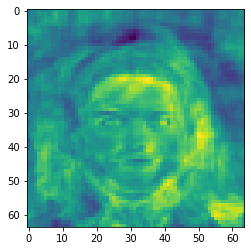

In [95]:
plt.imshow(ch[34])
plt.show()

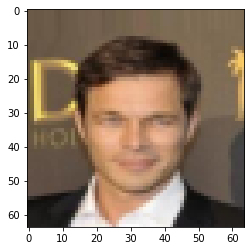

In [96]:
sample = resize(io.imread('images/img_align_celeba/image33.jpg'), (64,64))
plt.imshow(sample)
plt.show()

In [97]:
sample_dataset = dset.ImageFolder(root = 'D:\workspace\DCGAN\LSGAN_CelebA\LSGAN_CelebA\progress_pics',
                               transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader_sample = torch.utils.data.DataLoader(sample_dataset, batch_size=128,
                                         shuffle=True, num_workers=0)

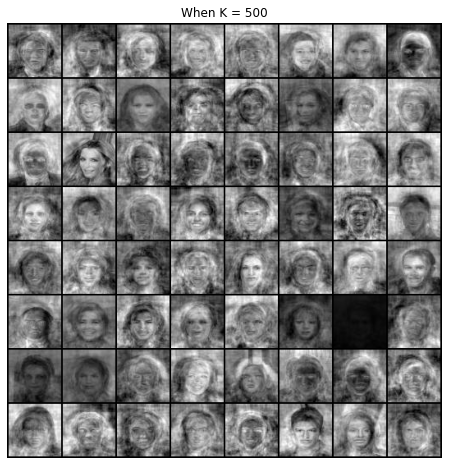

In [98]:
real_batch = next(iter(dataloader_sample))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("When K = 500")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))

image PCA를 통해 추출된 k component가 1인 face들을 모두 모아 평균값을 구해 project된 단 하나의 얼굴 이미지를 얻어낸다

In [99]:
pca_face = []

for i in range(2000):
    if i % 20 == 0:
        img = im.open(f'progress_pics/samples/pca_sample{i}.jpg')
        img2 = np.array(img).flatten()
        pca_face.append(img2)
    i += 1

pca_face_matrix = np.vstack(pca_face)
print(pca_face_matrix.shape)

(100, 4096)


(64, 64)


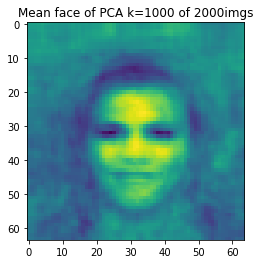

Lossy conversion from float64 to uint8. Range [101.69, 146.19]. Convert image to uint8 prior to saving to suppress this warning.


In [103]:
mean_face = np.mean(pca_face_matrix, axis=0)
print(mean_face.reshape(64,64).shape)
plt.imshow(mean_face.reshape(64,64))
plt.title('Mean face of PCA k=1000 of 2000imgs')
plt.show()
imageio.imwrite('progress_pics/PCA_mean_face_result.jpg',mean_face.reshape(64,64))